In [18]:
import os 

In [19]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold
import albumentations as A
from sklearn.model_selection import train_test_split
from tqdm import tqdm as tqdm
import time

In [21]:
MEAN = [0.485, 0.456, 0.406] 
STD = [0.229, 0.224, 0.225]
BATCH_SIZE = 1024
HEIGHT = 32
WIDTH = 32
N_EPOCHS = 10
N_FOLDS = 5
N_WORKERS = 4
INIT_LR = 0.01
RANDOM_STATE = 47
DATASET_DIR = "../data/"
MODEL_PATH = "../models/"
N_FOLDS = 5
FOLD = 0
device = torch.device("cuda")

In [22]:
df = pd.read_csv(DATASET_DIR + "data.csv")
classes = df.character.unique()

idx2class = {i:class_name for i, class_name in enumerate(classes)}
class2idx = {class_name:i for i, class_name in enumerate(classes)}

df["character_id"] = df.character.map(class2idx)

skf = StratifiedKFold(N_FOLDS, shuffle = True, random_state = RANDOM_STATE)
for i_fold, (train_idx, val_idx) in enumerate(skf.split(df, df.character)):
    df.loc[val_idx, "fold"] = i_fold
df.fold = df.fold.astype(np.int)

In [23]:
class Albumentations():
    def __init__(self, augmentations):
        self.augmentations  = A.Compose(augmentations)
    def __call__(self, image):
        return self.augmentations(image = image)["image"]


In [24]:
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations import functional as F

from PIL import Image, ImageOps, ImageEnhance
from albumentations.core.transforms_interface import ImageOnlyTransform

def int_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval .
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    An int that results from scaling `maxval` according to `level`.
    """
    return int(level * maxval / 10)


def float_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval.
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    A float that results from scaling `maxval` according to `level`.
    """
    return float(level) * maxval / 10.


def sample_level(n):
    return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
    return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
    return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
    level = int_parameter(sample_level(level), 4)
    return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
    degrees = int_parameter(sample_level(level), 30)
    if np.random.uniform() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
    level = int_parameter(sample_level(level), 256)
    return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)


def shear_y(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)


def translate_x(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)


# operation that overlaps with ImageNet-C's test set
def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)


augmentations = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y
]

augmentations_all = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y, color, contrast, brightness, sharpness
]

def normalize(image):
    """Normalize input image channel-wise to zero mean and unit variance."""
    return image - 127

def apply_op(image, op, severity):
    #   image = np.clip(image, 0, 255)
    print(image.shape)
    pil_img = Image.fromarray(image)  # Convert to PIL.Image
    pil_img = op(pil_img, severity)
    return np.asarray(pil_img)

def augment_and_mix(image, severity=3, width=3, depth=-1, alpha=1.):

    ws = np.float32(
      np.random.dirichlet([alpha] * width))
    m = np.float32(np.random.beta(alpha, alpha))

    mix = np.zeros_like(image).astype(np.float32)
    for i in range(width):
        image_aug = image.copy()
        depth = depth if depth > 0 else np.random.randint(1, 4)
        for _ in range(depth):
            op = np.random.choice(augmentations)
            image_aug = apply_op(image_aug, op, severity)
        # Preprocessing commutes since all coefficients are convex
        mix += ws[i] * image_aug
#         mix += ws[i] * normalize(image_aug)

    mixed = (1 - m) * image + m * mix
#     mixed = (1 - m) * normalize(image) + m * mix
    return mixed


class RandomAugMix(ImageOnlyTransform):

    def __init__(self, severity=3, width=3, depth=-1, alpha=1., always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.severity = severity
        self.width = width
        self.depth = depth
        self.alpha = alpha

    def apply(self, image, **params):
        image = augment_and_mix(
            image,
            self.severity,
            self.width,
            self.depth,
            self.alpha
        )
        return image



    
class GridMask(DualTransform):
    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                # this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                this_mask = np.zeros((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)

                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = F.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image =np.maximum(image , mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype))
        # image =image | mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

In [25]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, folds , mode, transform = None, transform_orig = None):
        df = df[df.fold.isin(folds)].reset_index(drop = True)
        self.images= df.drop(['character','fold', "character_id"], axis = 1).values
        self.labels = df['character_id'].values
        self.mode = mode
        self.transforms = transform
        self.transforms_orig = transform_orig
        
    def __len__(self):
        return self.images.shape[0]
    
    def __mode__(self):
        return self.mode
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        image = image.reshape((HEIGHT, WIDTH))
        image_orig = image.copy()
        if self.transforms:
            image = self.transforms(image)
        if self.transforms_orig:
            image_orig = self.transforms_orig(image_orig)
        
        return torch.tensor(image), torch.tensor(image_orig), torch.tensor(label)

In [26]:
preprocess=[
    
]

augmentations = [
    A.PadIfNeeded(min_height=HEIGHT, min_width=WIDTH, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255], always_apply=True),
    A.OneOf([
        A.ShiftScaleRotate(rotate_limit=300, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255], mask_value=[255, 255, 255], always_apply=True),
        # GridMask(num_grid=5, mode=2, rotate=int(np.random.randint(0,15)), fill_value= 128.0  )
    ], 0.5)
]
transforms_train = transforms.Compose([
    np.uint8,
    Albumentations(preprocess + augmentations),
    transforms.ToTensor(),
#     transforms.Normalize(mean = MEAN, std = STD)
])

transforms_val = transforms.Compose([
    np.uint8,
    Albumentations(preprocess),
    transforms.ToTensor(),
#     transforms.Normalize(mean = MEAN, std = STD)
    
])
transforms_orig = transforms.Compose([
    np.uint8,
    Albumentations(preprocess),
    transforms.ToTensor(),
])


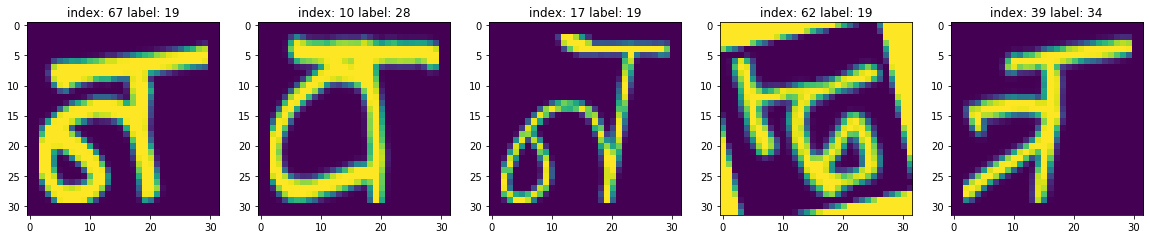

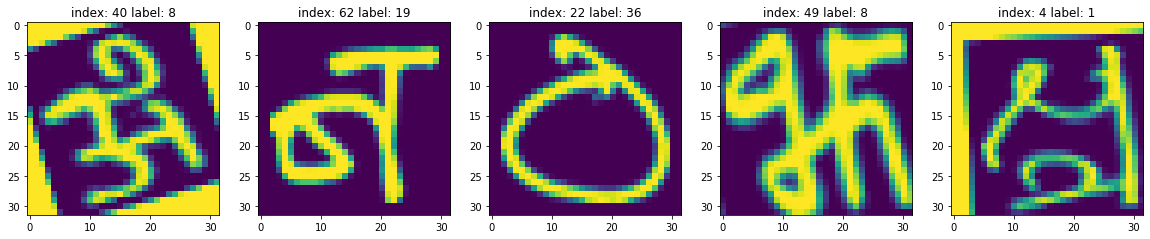

In [27]:
df_show = df.sample(n = 100)

dataset_show = Dataset( df_show, [0,1,2,3],"train",transforms_train, transforms_orig )

from pylab import rcParams
rcParams["figure.figsize"] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, img_orig, label = dataset_show[idx]
        axarr[p].imshow(img.transpose(0,1).transpose(1,2).squeeze())
        axarr[p].set_title("index: "+ str(idx)+" label: " + str(label.item()))

In [28]:
import pretrainedmodels
import torch.nn as nn
from torch.nn import functional as F


class nn_model(nn.Module):
    def __init__(self, pretrained):
        super(nn_model, self).__init__()

        if pretrained:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained = "imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained = None)

        self.front = nn.Conv2d(1, 3, (1, 1), stride= 1, padding = 0)
        self.l2 = nn.Linear(512, 47)

    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.front(x)
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        
        l2 = self.l2(x)

        return l2


In [29]:
def criterion(logits, targets):
    return nn.CrossEntropyLoss()(logits, targets)

def criterion_mix(logits, target):
    target, shuffled_target, lam = target
    loss = nn.CrossEntropyLoss()(logits, target)
    loss_mix = nn.CrossEntropyLoss()(logits, shuffled_target)
    
    return lam * loss  + (1- lam) * loss_mix


def rand_bbox(size, lam):
    W = size[-2]
    H = size[-1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

    
def cutmix(data, target, alpha, clip=[0.3, 0.7]):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]
    lam = np.clip(np.random.beta(alpha, alpha), clip[0], clip[1])
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.shape, lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = shuffled_data[:, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return data, targets

In [30]:
def train_epoch(loader, optimizer):
    model.train()
    bar = tqdm(loader)
    train_loss = []
    for(data, data_orig, targets) in bar:
        optimizer.zero_grad()
        data, data_orig, targets = data.to(device), data_orig.to(device),targets.to(device)
        
        loss_fnc = criterion

        randp = np.random.rand()
        if randp < 1.5:
            data, targets = cutmix(data_orig, targets, 1.0)
            loss_fnc = criterion_mix
        

        logits = model(data)
        loss = loss_fnc(logits, targets)
        loss.backward()
        optimizer.step()
        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-20:])/min(len(train_loss), 20)

        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))

    return train_loss

def val_epoch(loader):
    model.eval()
    val_loss = []
    outputs = []
    acc = 0
    pred = []
    with torch.no_grad():
        for (data, data_orig, target) in tqdm(loader):
            data, data_orig, target = data.to(device), data_orig.to(device), target.to(device)
            logits = model(data)
            loss = criterion(logits, target)
            pred = nn.Softmax()(logits).argmax(1).detach()
            outputs.append(pred)
            acc += (target == pred).sum().detach().cpu().numpy()

            val_loss.append(loss.cpu().numpy())
        val_loss = np.mean(val_loss)
        acc /= len(dataset_valid)

    return val_loss, acc


In [31]:
for i in range(N_FOLDS):
    print(df[df.fold == i].character_id.value_counts())

31    400
35    400
38    400
22    400
6     400
37    400
21    400
5     400
36    400
20    400
4     400
19    400
15    400
3     400
34    400
18    400
2     400
33    400
17    400
1     400
32    400
16    400
7     400
23    400
39    400
8     400
30    400
14    400
45    400
29    400
13    400
44    400
28    400
12    400
43    400
27    400
11    400
42    400
26    400
10    400
41    400
25    400
9     400
40    400
24    400
0     400
Name: character_id, dtype: int64
31    400
35    400
38    400
22    400
6     400
37    400
21    400
5     400
36    400
20    400
4     400
19    400
15    400
3     400
34    400
18    400
2     400
33    400
17    400
1     400
32    400
16    400
7     400
23    400
39    400
8     400
30    400
14    400
45    400
29    400
13    400
44    400
28    400
12    400
43    400
27    400
11    400
42    400
26    400
10    400
41    400
25    400
9     400
40    400
24    400
0     400
Name: character_id, dtype: int64
31    400
35  

In [32]:
n_folds = N_FOLDS
record = [{'train_loss': [], 'val_loss': [], "score": []} for x in range(n_folds)]

fold = FOLD
i_fold = fold
folds = [i for i in range(n_folds)]
train_idx, valid_idx = np.where((df['fold'] != i_fold))[0], np.where((df['fold'] == i_fold))[0]

train_folds = []
val_folds = []
for i in range(n_folds):
    if i == fold:
        val_folds.append(i)
    else:
        train_folds.append(i)

dataset_train = Dataset( df, train_folds,"train",transforms_train, transforms_orig )

dataset_valid = Dataset( df, val_folds ,"val",transforms_val, transforms_orig )

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True,num_workers=0)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False, sampler=None, num_workers=0)

model = nn_model(pretrained= True)
model = model.to(device)

max_acc = 0
model_file = f"{MODEL_PATH}resnet34_pretrained_best_fold_{i_fold}.pth"

optimizer = torch.optim.Adam(model.parameters(), lr = INIT_LR)

In [33]:
for epoch in range(1, N_EPOCHS+1):
    print(time.ctime(), 'Epoch:', epoch)
 
    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}'
    
    print(content)
    with open(f"log_resnet34.txt", "a") as appender:
        appender.write(content + "\n")
    
    if (epoch)%2==0:
        print(f"Saving model on epoch {epoch}")
        torch.save(model.state_dict(), f'{MODEL_PATH}resnet34_{epoch}_fold{i_fold}.pth')

    if acc > max_acc:
        max_acc = acc
        print('acc ({:.6f} --> {:.6f}).  Saving model ...'.format(max_acc, acc))
        torch.save(model.state_dict(), model_file)

torch.save(model.state_dict(), os.path.join(f'resnet34_model_fold{i_fold}.pth'))


  0%|          | 0/72 [00:00<?, ?it/s]Sun May 31 18:44:51 2020 Epoch: 1

loss: 3.97567, smth: 4.20967:  28%|██▊       | 20/72 [00:23<00:59,  1.13s/it]

In [ ]:
for(data, data_orig, targets) in train_loader:
    print(data_orig.shape)
    data, targets = cutmix(data_orig, targets, 1.0)
    print(data.shape)
    break